In [70]:
import numpy as np
import pandas as pd
import networkx as nx
import osmnx as ox
import math
import pandas as pd
import random
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
 
from funciones import read_data, calcular_distancia, calcular_matriz_dist, calcular_largo_ruta, graficar_ruta
from solvers_listos import generar_ruta, graficar_rutas 
# from instancia import ubis, cap_tpte, info_locales
# from instancia import G, color_nodos, color_arcos, ancho_edges
from instancia import crear_grafo_inicial
from ruteo_alns import ruteo_ALNS

random.seed(1)
np.random.seed(1)

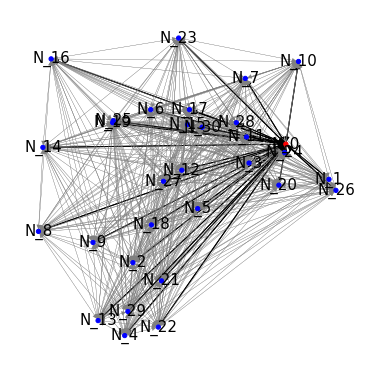

{'Inv': 3773, 'Up': 1000000, 'Low': 0, 'Prod': 1508, 'h': 0.3, 'coord_x': 407, 'coord_y': 331, 'pos': (407, 331)}
{'Inv': 40, 'Up': 80, 'Low': 0, 'Prod': 40, 'h': 0.33, 'coord_x': 475, 'coord_y': 277, 'pos': (475, 277)}
{'Inv': 24, 'Up': 48, 'Low': 0, 'Prod': 24, 'h': 0.41, 'coord_x': 166, 'coord_y': 149, 'pos': (166, 149)}
{'Inv': 120, 'Up': 180, 'Low': 0, 'Prod': 60, 'h': 0.47, 'coord_x': 349, 'coord_y': 302, 'pos': (349, 302)}
{'Inv': 77, 'Up': 154, 'Low': 0, 'Prod': 77, 'h': 0.36, 'coord_x': 153, 'coord_y': 37, 'pos': (153, 37)}
{'Inv': 124, 'Up': 186, 'Low': 0, 'Prod': 62, 'h': 0.48, 'coord_x': 268, 'coord_y': 232, 'pos': (268, 232)}
{'Inv': 82, 'Up': 123, 'Low': 0, 'Prod': 41, 'h': 0.24, 'coord_x': 194, 'coord_y': 384, 'pos': (194, 384)}
{'Inv': 128, 'Up': 192, 'Low': 0, 'Prod': 64, 'h': 0.48, 'coord_x': 343, 'coord_y': 432, 'pos': (343, 432)}
{'Inv': 56, 'Up': 112, 'Low': 0, 'Prod': 56, 'h': 0.49, 'coord_x': 17, 'coord_y': 197, 'pos': (17, 197)}
{'Inv': 16, 'Up': 32, 'Low': 0, '

In [71]:
G, ubis, cap_tpte, info_locales = crear_grafo_inicial(archivo= 'IRP3.xlsx' ,plot=True)
for nodo in G.nodes(data=True):
    si_o_no = random.randint(0,1)
    if False and nodo[0] != 'N_0':
        up = nodo[1]['Up']
        new_d = random.randint(int(up*0.25), int(up*0.75))
        G.nodes[nodo[0]]['Prod'] = new_d
        G.nodes[nodo[0]]['Inv'] = up - new_d

    print(G.nodes(data=True)[nodo[0]])

In [72]:
def reaccion_inventario(grafo, mu, sd, alfa = 0.05):
    """
    Función que verifica que locales deben ser visitados en base a su inventario actual. 
    En caso de que el inventario se encuentre bajo el umbral de tolerancia, se retorna True.
    """
    grafo = G.copy()
    visitas = {nodo : False for nodo in G.nodes()}
    for nodo in grafo.nodes(data=True):
        id_nodo = int(nodo[0][2:])-1
        media = mu[id_nodo]
        desviacion = sd[id_nodo]
        s = media + norm.ppf((1 - alfa)/2) * desviacion  #Stock de segrafouridad
        if nodo[1]['Inv'] <= s:
            visitas[nodo[0]] = True
    
    return visitas

In [73]:
def IC_nrm(mu, sd, M=1000, alfa = 0.95):
    """
    Función que calcula el intervalo de confianza para una distribución normal.
    """
    limite_inferior = mu + norm.ppf((1 - alfa) / 2) * sd / math.sqrt(M)
    limite_superior = mu - norm.ppf((1 - alfa) / 2) * sd / math.sqrt(M)
    
    return limite_inferior, limite_superior

In [74]:
def simular_demanda_previa(G, dist = 'n', T =100, ruido = 0):
    """
    Función que simula la demanda previa de los locales.
    """
    g = G.copy()
    demandas = {nodo : [] for nodo in g.nodes() if nodo != 'N_0'}
    # r = {nodo : nodo[1]['Prod'] for nodo in G.nodes(data=True)}
    if dist == 'n':
        for nodo in g.nodes(data=True):
            # print(nodo[0],nodo[1]['Prod'])
            if nodo[0] != 'N_0':
                dem_pasadas = [max(
                    np.random.normal(loc = nodo[1]['Prod'], scale = nodo[1]['Prod'] * 0.05) 
                    + np.random.normal(loc = 0, scale = nodo[1]['Prod'] * ruido)
                    ,0) for _ in range(T)]
                demandas[nodo[0]] = dem_pasadas
         
    return demandas

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

#ejemplo demanda historica

muestra = False

if muestra:
    dem_historico = simular_demanda_previa(G, dist = 'n', T=1000, ruido=0.05) 
    demanda = {nodo: dem_historico[nodo][-1] for nodo in dem_historico.keys()}
    print(demanda)
    print(dem_historico.keys())
    plt.figure(figsize=(10, 5))
    plt.plot(demanda.values(), 'o', color='black') 
    # for nodo in dem_historico.keys():
    #     if nodo != 'N_0':
    #         # plt.plot(dem_historico[nodo])
    #         plt.plot(smooth(dem_historico[nodo], 10))
    plt.xlabel('Días')
    plt.ylabel('Demanda')
    plt.xticks(np.arange(len(demanda)), demanda.keys())
    plt.title('Demanda histórica')
    plt.show()


In [75]:
def SEDA(datos, historia = False, alpha=0.1, beta=0.1, theta=0.5):
    '''
    Suavizamiento Exponencial Doble Amortiguado
    Aplica el método de suavizamiento exponencial doble a una serie de datos,
    específicmamente el Método de Holt Damped.
    '''
    I = [datos[0]]
    S = [datos[1]-datos[0]]
    for i in range(1,len(datos)):
        I.append(alpha*datos[i] + (1-alpha)*(I[i-1]+ theta*S[i-1]))
        S.append(beta*(I[i]-I[i-1])+(1-beta)*S[i-1])
    
    y = I[-1] + theta * S[-1]
    if historia == False:
        return y
    elif historia == True:
        I.append(y)
        return I
    elif historia == 'S':
        return I, S
    
def pronostico_SEDA(datos, T, pron = False, alpha=0.1, beta=0.1, theta=0.5):
    '''
    Devuelve un pronóstico para los siguientes T periodos mediante Suavizamiento Exponencial Doble Amortiguado
    '''
    I,S = SEDA(datos, historia = 'S', alpha=alpha, beta=beta, theta=theta)
    pronostico = []
    for i in range(T):
        y = I[-1] + theta * S[-1]
        pronostico.append(y)
        I.append(alpha*y + (1-alpha)*(I[-1]+ theta*S[-1]))
        S.append(beta*(I[-1]-I[-2]) + (1-beta)*S[-1])
    
    return pronostico

muestra = False

if muestra:
    dem_historico = simular_demanda_previa(G, dist = 'n', T=1000, ruido = 0.05) 
    demanda = {nodo: dem_historico[nodo][-1] for nodo in dem_historico.keys()}
    data = {nodo: dem_historico[nodo][1:] for nodo in dem_historico.keys()}
    y = [SEDA(data[nodo], historia=False, alpha = 0.5) for nodo in data.keys()]
    medias = [np.mean(data[nodo]) for nodo in data.keys()]
    ind = np.arange(len(y))

    # y = [SEDA(dem_historico[nodo], pron=True, alpha = 0.5) for nodo in set(dem_historico)-set(['N_0'])]
    # medias = [np.mean(dem_historico[nodo]) for nodo in set(dem_historico)-set(['N_0'])]
    # ind = np.arange(len(y))
    
    # print(y)
    ancho = 0.3
    plt.figure(figsize=(10, 5))
    plt.plot(y, 'o', label='Pronóstico', color='red')
    plt.plot(medias, 'o', label='Promedio', color='blue')
    plt.plot(demanda.values(), 'o', label='Realización', color='black')
    # plt.bar(ind, y, width=ancho, label='Pronóstico', color='red')
    # plt.bar(ind + ancho, medias, width=ancho, label='Promedio', color='blue')
    plt.xticks(ind + ancho / 2, [f'N_{i}' for i in range(1,len(y)+1)])

    plt.xlabel('Local')
    plt.ylabel('Demanda')
    plt.title('Demanda: Pronóstico y realización para t+1')
    plt.legend()
    plt.show()

In [76]:
for nodo in G.nodes(data=True):
    print(nodo[0],nodo[1]['Inv'])

N_0 3773
N_1 40
N_2 24
N_3 120
N_4 77
N_5 124
N_6 82
N_7 128
N_8 56
N_9 16
N_10 36
N_11 44
N_12 196
N_13 86
N_14 84
N_15 70
N_16 55
N_17 158
N_18 164
N_19 46
N_20 48
N_21 98
N_22 36
N_23 64
N_24 64
N_25 48
N_26 56
N_27 14
N_28 37
N_29 98
N_30 96


In [77]:
def ejecutar_ruta(G,ruta,matriz_dst):
    """
    Función que simula la ejecución de una ruta.
    """
    g = G.copy()
    ruta = ruta.copy()
    ruta.pop(0)
    ruta.pop(-1)
    ruta = [int(nodo[2:]) for nodo in ruta]
    # distancia = calcular_largo_ruta(ruta, matriz_dst)
    stock = 0
    for nodo in ruta:
        stock += g.nodes[f'N_{nodo}']['Up'] - G.nodes[f'N_{nodo}']['Inv']
        g.nodes[f'N_{nodo}']['Inv'] = G.nodes[f'N_{nodo}']['Up']
    g.nodes['N_0']['Inv'] -= stock
    return g, stock

def realizacion_demanda(G, ruido = 0.05):
    """
    Función que simula la demanda de los locales para un determinado periodo.
    """
    grafo = G.copy()
    demandas = {nodo : [] for nodo in G.nodes() if nodo != 'N_0'}
    insatisfecho = 0
    for nodo in grafo.nodes(data=True):
        if nodo[0] != 'N_0':
            dem = max(
                np.random.normal(loc = nodo[1]['Prod'], scale = nodo[1]['Prod'] * 0.05) 
                + np.random.normal(loc = 0, scale = nodo[1]['Prod'] * 0.05)
                ,0)
            demandas[nodo[0]] = dem
            if dem <= grafo.nodes[nodo[0]]['Inv']:
                grafo.nodes[nodo[0]]['Inv'] -= dem
            else:
                grafo.nodes[nodo[0]]['Inv'] = 0
                insatisfecho += dem - grafo.nodes[nodo[0]]['Inv']

    return grafo, demandas, insatisfecho
Gprima, d, ins = realizacion_demanda(G)

for nodo in Gprima.nodes(data=True):
    print(nodo[0],nodo[1]['Inv'])

N_0 3773
N_1 0
N_2 1.92136844930355
N_3 64.30839320266682
N_4 0
N_5 61.784026966202966
N_6 42.225967183528
N_7 66.26070898778215
N_8 0
N_9 0.8402293003774446
N_10 0
N_11 0
N_12 91.11998320847614
N_13 42.53317460630633
N_14 44.223185285533205
N_15 34.54068207255371
N_16 2.993139266098538
N_17 85.05289444939235
N_18 84.80403399199845
N_19 2.030657696881825
N_20 21.117784394775352
N_21 51.644688065293806
N_22 17.14923332345078
N_23 32.93790062686932
N_24 0
N_25 0
N_26 28.072911337152767
N_27 1.0443026443045138
N_28 0
N_29 0
N_30 0


In [78]:
dem_historico_test = simular_demanda_previa(G, dist = 'n', T=1000) 
mu_d = [np.mean(dem_historico_test[nodo]) for nodo in dem_historico_test.keys()]    
sd_d = [np.std(dem_historico_test[nodo]) for nodo in dem_historico_test.keys()]
vis = reaccion_inventario(G, mu_d, sd_d)
np.sum(mu_d)

1508.683457554266

In [79]:
def simular_ejecucion_R(grafo_inicial = G, T=1):
    # Inicializar variables     
    # ---------------------
    G0 = grafo_inicial.copy()
    matriz_dst = calcular_matriz_dist(G0)
    ubicaciones = list(G0.nodes()) # Lista de ubicaciones
    inventarios = [G0.nodes(data=True)[i]['Inv'] for i in ubicaciones] # Lista de inventarios
    h = [G0.nodes(data=True)[i]['h'] for i in ubicaciones] # Lista de costos de inventario
    rutas = {t : [] for t in range(T)} # Lista de rutas
    dem_historico = simular_demanda_previa(G0, dist = 'n', T=1000) 
    perdido = 0
    print("Inventario inicial: ")
    for nodo in G0.nodes(data=True):
            print(nodo[0],nodo[1]['Inv'])
    print("\n")

    for t in range(T):
        mu_demanda = [np.mean(dem_historico[nodo]) for nodo in dem_historico.keys()]    
        sd_demanda = [np.std(dem_historico[nodo]) for nodo in dem_historico.keys()]
        # pronostico = [pronostico_SEDA(dem_historico[nodo], T = 10, pron = True, alpha=0.1, beta=0.1, theta=0.5) for nodo in dem_historico.keys()]

        # Estrategia Reactiva (R)  
        visitas_reaccion = reaccion_inventario(G0, mu_demanda, sd_demanda)
        # print("Visitas reacción: ", visitas_reaccion)
        
        if sum(visitas_reaccion.values()) == 0:
            print("No hay locales que visitar")
            rutas[t] = []

        else:    
            ruta_R, largo_ruta_R = generar_ruta(G0, matriz_dst, visitas_reaccion) #devuelve la ruta a realizar
            rutas[t] = ruta_R
            print(f"Ruta {t}: ", ruta_R )
            G0, stock = ejecutar_ruta(G0, ruta_R, matriz_dst)
            
        G0, demanda, insatisfecho = realizacion_demanda(G0)
        perdido += insatisfecho

        inventarios = [G0.nodes(data=True)[i]['Inv'] for i in ubicaciones]

        costo = sum([h[i]*inventarios[i] for i in range(len(inventarios))])
        
        for nodo in ubicaciones:
            if nodo != 'N_0':
                dem_historico[nodo].append(demanda[nodo])
    print('\n')
    print("Inventario final: ")
    for nodo in G0.nodes(data=True):
        print(nodo[0],nodo[1]['Inv'])
    print(f'Demanda perdida total: {perdido} | Demanda perdida promedio: {perdido/T}')
    
    return rutas, dem_historico
        
        
mis_rutas, dem_historico = simular_ejecucion_R(grafo_inicial = G, T = 365)
        

Inventario inicial: 
N_0 3773
N_1 40
N_2 24
N_3 120
N_4 77
N_5 124
N_6 82
N_7 128
N_8 56
N_9 16
N_10 36
N_11 44
N_12 196
N_13 86
N_14 84
N_15 70
N_16 55
N_17 158
N_18 164
N_19 46
N_20 48
N_21 98
N_22 36
N_23 64
N_24 64
N_25 48
N_26 56
N_27 14
N_28 37
N_29 98
N_30 96


Ruta 0:  ['N_0', 'N_8', 'N_0']
Ruta 1:  ['N_0', 'N_8', 'N_0']
Ruta 2:  ['N_0', 'N_8', 'N_0']
Ruta 3:  ['N_0', 'N_8', 'N_0']


Ruta 4:  ['N_0', 'N_8', 'N_0']
Ruta 5:  ['N_0', 'N_8', 'N_0']
Ruta 6:  ['N_0', 'N_8', 'N_0']
Ruta 7:  ['N_0', 'N_8', 'N_0']
Ruta 8:  ['N_0', 'N_8', 'N_0']
Ruta 9:  ['N_0', 'N_8', 'N_0']
Ruta 10:  ['N_0', 'N_8', 'N_0']
Ruta 11:  ['N_0', 'N_8', 'N_0']
Ruta 12:  ['N_0', 'N_8', 'N_0']
Ruta 13:  ['N_0', 'N_8', 'N_0']
Ruta 14:  ['N_0', 'N_8', 'N_0']
Ruta 15:  ['N_0', 'N_8', 'N_0']
Ruta 16:  ['N_0', 'N_8', 'N_0']
Ruta 17:  ['N_0', 'N_8', 'N_0']
Ruta 18:  ['N_0', 'N_8', 'N_0']
Ruta 19:  ['N_0', 'N_8', 'N_0']
Ruta 20:  ['N_0', 'N_8', 'N_0']
Ruta 21:  ['N_0', 'N_8', 'N_0']
Ruta 22:  ['N_0', 'N_8', 'N_0']
Ruta 23:  ['N_0', 'N_8', 'N_0']
Ruta 24:  ['N_0', 'N_8', 'N_0']
Ruta 25:  ['N_0', 'N_8', 'N_0']
Ruta 26:  ['N_0', 'N_8', 'N_0']
Ruta 27:  ['N_0', 'N_8', 'N_0']
Ruta 28:  ['N_0', 'N_8', 'N_0']
Ruta 29:  ['N_0', 'N_8', 'N_0']
Ruta 30:  ['N_0', 'N_8', 'N_0']
Ruta 31:  ['N_0', 'N_8', 'N_0']
Ruta 32:  ['N_0', 'N_8', 'N_0']
Ruta 33:  ['N_0', 'N_8', 'N_0']
Ruta 34:  ['N_0', 'N_8', 'N_0']
Ruta 35:  ['N_

In [80]:
from ruteo_alns import ruteo_ALNS
def simular_ejecucion_P(grafo_inicial = G, T=1, F=1, cap = cap_tpte/2):
    # Inicializar variables     
    # ---------------------
    G0 = grafo_inicial.copy()
    matriz_dst = calcular_matriz_dist(G0)
    ubicaciones = list(G0.nodes()) # Lista de ubicaciones
    inventarios = [G0.nodes(data=True)[i]['Inv'] for i in ubicaciones] # Lista de inventarios
    h = [G0.nodes(data=True)[i]['h'] for i in ubicaciones] # Lista de costos de inventario
    rutas = {t : None for t in range(T)} # Lista de rutas
    dem_historico = simular_demanda_previa(G0, dist = 'n', T=1000) 
    perdido = 0
    print("Inventario inicial: ")
    for nodo in G0.nodes(data=True):
            print(nodo[0],nodo[1]['Inv'])
    print("\n")

    for t in range(T):
        pronostico = {int(nodo[2:]):
                pronostico_SEDA(dem_historico[nodo], T = 1, pron = True, alpha=0.2, beta=0.1, theta=0.5)[0]
                for nodo in dem_historico.keys()}
        # print(pronostico)
         
        ruta_P = ruteo_ALNS(G0, pronostico, cap = cap, F = F, ruta = True, MRT = 10) + ['N_0']
        rutas[t] = ruta_P
        print(f"Ruta {t}: ", ruta_P )
        # visitas_proactiva = proactiva_inventario(G0, tolerancia = 0.2, dist = 'n', mu = 0, sigma = 0.1, M = 1000)

        G0, stock = ejecutar_ruta(G0, ruta_P, matriz_dst)
        G0, demanda, insatisfecho = realizacion_demanda(G0)
        
        perdido += insatisfecho

        #Actualizo demandas
        for nodo in ubicaciones:
            if nodo != 'N_0':
                dem_historico[nodo].append(demanda[nodo])


    print('\n')
    print("Inventario final: ")
    for nodo in G0.nodes(data=True):
        print(nodo[0],nodo[1]['Inv'])
    print(f'Demanda perdida total: {perdido} | Demanda perdida promedio: {perdido/T}')        

    graficar_rutas(rutas, G0)

simular_ejecucion_P(grafo_inicial = G, T = 5)

Inventario inicial: 
N_0 3773
N_1 40
N_2 24
N_3 120
N_4 77
N_5 124
N_6 82
N_7 128
N_8 56
N_9 16
N_10 36
N_11 44
N_12 196
N_13 86
N_14 84
N_15 70
N_16 55
N_17 158
N_18 164
N_19 46
N_20 48
N_21 98
N_22 36
N_23 64
N_24 64
N_25 48
N_26 56
N_27 14
N_28 37
N_29 98
N_30 96




KeyError: 24

In [ ]:
mis_rutas
mis_rutas_t = {t : str(mis_rutas[t]) for t in mis_rutas.keys()}
df_rutas = pd.DataFrame.from_dict(mis_rutas_t, orient='index', columns=['Ruta'])
df_rutas.value_counts()

Ruta                 
[]                       310
['N_0', 'N_4', 'N_0']     55
Name: count, dtype: int64

## Procesamiento de Resultados

In [ ]:
N = len(G.nodes())-1
def generar_df(rutas, N):

    rutas_bool = dict()
    for ruta, nodos in rutas.items():
        bools = dict()
        for i in range(1, N+1):
            if f'N_{i}' in nodos:
                bools[f'N_{i}'] = 1
            else:
                bools[f'N_{i}'] = 0
        rutas_bool[ruta] = bools
    
    df = pd.DataFrame.from_dict(rutas_bool, orient='index')
    
    df.rename(columns={'index': 'Ruta', 0: 'Nodo'}, inplace=True)
    df.rename_axis('Ruta', inplace=True)
    return df

df = generar_df(mis_rutas, N)
df['sum'] = df.sum(axis=1)


In [ ]:
df_nodos = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
df_nodos = df_nodos.iloc[1:]
df_nodos['frec'] = (df.describe()).T['mean']
dem_historico_media = {nodo: np.mean(dem_historico[nodo]) for nodo in dem_historico.keys()}
df_nodos['dem_mean'] = dem_historico_media.values()
df_nodos

,Inv,Up,Low,Prod,h,coord_x,coord_y,pos,frec,dem_mean
N_1,87,174,0,87,0.23,200,100,"(200, 100)",0.0,86.952561
N_2,27,54,0,27,0.32,150,100,"(150, 100)",0.0,27.023368
N_3,20,30,0,10,0.33,250,100,"(250, 100)",0.0,10.003382
N_4,55,110,0,55,0.23,200,75,"(200, 75)",0.0,54.908577
N_5,142,213,0,71,0.18,200,125,"(200, 125)",0.0,70.809480
N_6,69,138,0,69,0.29,-200,100,"(-200, 100)",1.0,69.282955
N_7,158,237,0,79,0.42,-150,100,"(-150, 100)",0.0,78.938202
N_8,86,129,0,43,0.42,-250,100,"(-250, 100)",0.0,43.123263
N_9,77,154,0,77,0.24,-200,75,"(-200, 75)",0.0,77.092827
N_10,126,189,0,63,0.43,-200,125,"(-200, 125)",0.0,62.903784


In [ ]:
indices_mayores = df_nodos[df_nodos['frec'] > 0.75].index
indices_medios = df_nodos[(df_nodos['frec'] > 0.45) & (df_nodos['frec'] <= 0.75)].index
indices_menores = df_nodos[df_nodos['frec'] <= 0.45].index

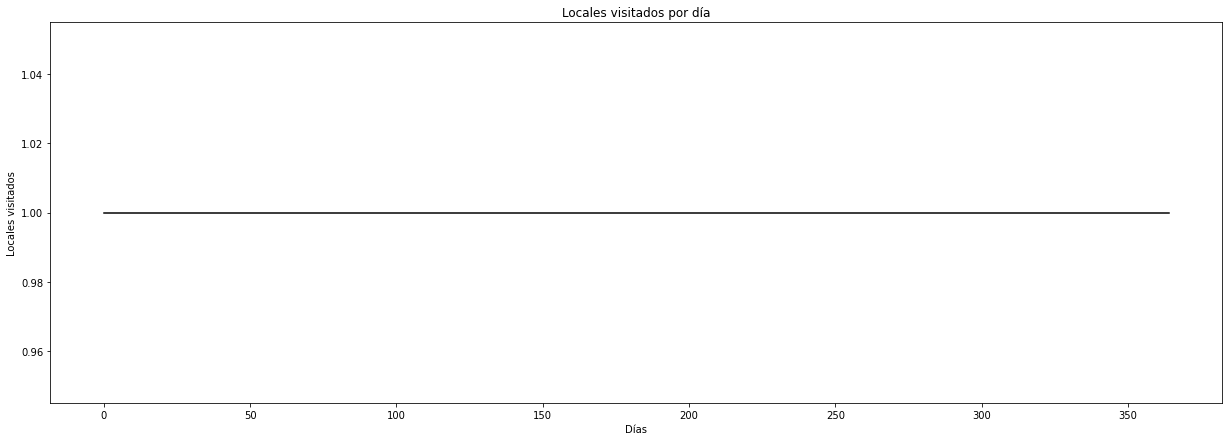

In [ ]:
# graficaremos una serie de tiempo para el total de locales en cada día
# para esto, debemos sumar la cantidad de locales visitados en cada día, ya lo hicimos en la última columna

plt.figure(figsize=(21, 7))
plt.plot(df['sum'], '-', color='black')
plt.xlabel('Días')
plt.ylabel('Locales visitados')
plt.title('Locales visitados por día')
plt.show()

In [ ]:
"""
# replicamos algo así pero ahora para cada local en vez de la suma, lo haremos sobre el mismo gráfico
# lo haremos solo con los primeros 150 días
plt.figure(figsize=(30, 7))
for i in range(1, N+1):
    plt.plot(df[f'N_{i}'][:150], '-', label=f'N_{i}')
plt.xlabel('Días')
plt.ylabel('Locales visitados')
plt.title('Locales visitados por día')
plt.legend()
plt.show()
"""

"\n# replicamos algo así pero ahora para cada local en vez de la suma, lo haremos sobre el mismo gráfico\n# lo haremos solo con los primeros 150 días\nplt.figure(figsize=(30, 7))\nfor i in range(1, N+1):\n    plt.plot(df[f'N_{i}'][:150], '-', label=f'N_{i}')\nplt.xlabel('Días')\nplt.ylabel('Locales visitados')\nplt.title('Locales visitados por día')\nplt.legend()\nplt.show()\n"

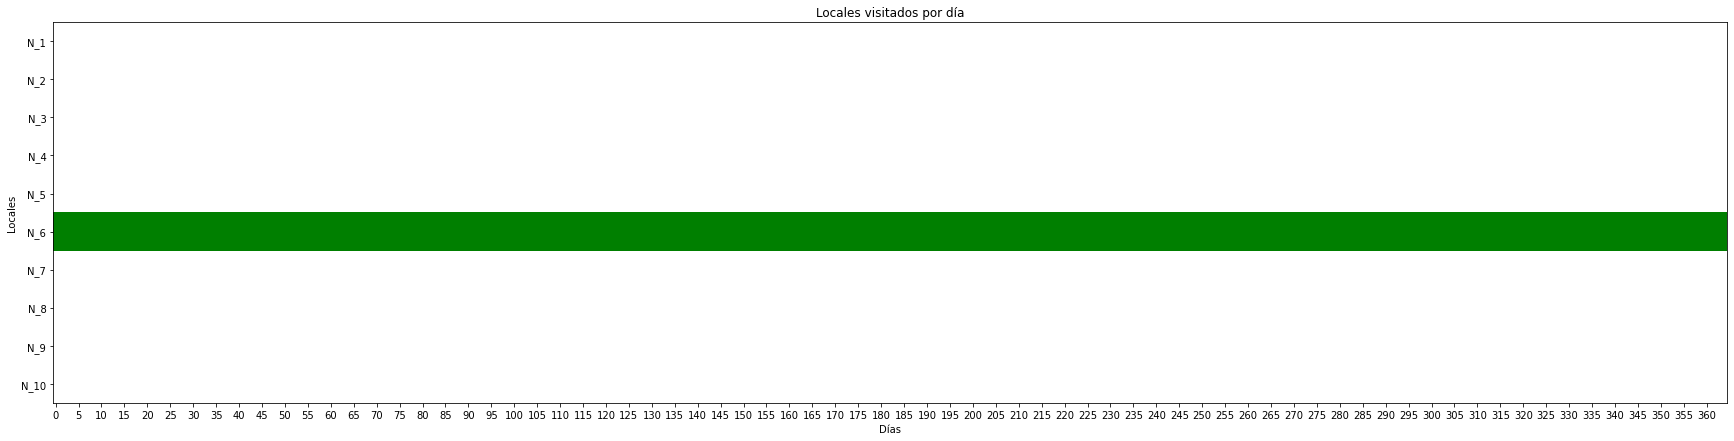

In [ ]:

from matplotlib.colors import ListedColormap


# Define colormap

cmap = ListedColormap(['w', 'g'], N=2)

# Plot matrix

fig, ax = plt.subplots(figsize=(30, 7))
if 'sum' in df.columns:
    df.drop('sum', axis=1, inplace=True)
df.sort_values(by='frec', ascending=False, inplace=True)
ax.imshow(df.T, cmap=cmap, vmin=0, vmax=1, aspect='auto')
ax.set_title('Locales visitados por día')
ax.set_xlabel('Días')
ax.set_ylabel('Locales')
ax.set_yticks(np.arange(N))
ax.set_yticklabels([f'N_{i}' for i in range(1, N+1)])
ax.set_xticks(np.arange(0, len(df), 5))

# modificamos el tamaño de la figura

plt.show()

In [ ]:
cantidad_06 = len(df_nodos[df_nodos['frec'] >= 0.5])
cantidad_04 = len(df_nodos[df_nodos['frec'] < 0.5])

print (f'Locales visitados más de 50% de los días: {cantidad_06}, que corresponde a un {cantidad_06/N*100}%')
print (f'Locales visitados menos de 50% de los días: {cantidad_04}, que corresponde a un {cantidad_04/N*100}%')

Locales visitados más de 50% de los días: 1, que corresponde a un 10.0%
Locales visitados menos de 50% de los días: 9, que corresponde a un 90.0%


In [ ]:
def dispersion_intervalos(df):
    '''
    Función que calcula la cantidad promedio de días entre visitas a cada local.
    También entrega la desviación estándar de los intervalos.
    '''
    df = df.copy()
    if 'sum' in df.columns:
        df.drop('sum', axis=1, inplace=True)
    datos = {nodo: {'mean': None, 'std': None} for nodo in df.columns}
    for nodo in df.columns:
        largos = []
        ultima_visita = 0
        for dia in range(len(df)):
            if df[nodo][dia] == 1:
                if dia - ultima_visita > 3:
                    #print(f'El local {nodo} no fue visitado por {dia - ultima_visita} días')
                    pass
                largos.append(dia - ultima_visita)
                ultima_visita = dia
        datos[nodo]['mean'] = np.mean(largos)
        datos[nodo]['std'] = np.std(largos)
    datos_df = pd.DataFrame.from_dict(datos, orient='index')
    return datos_df

datos = dispersion_intervalos(df)
        

df_nodos['mean'] = datos['mean']
df_nodos['std'] = datos['std']
df_nodos['porcentaje demanda'] = df_nodos['dem_mean'] / df_nodos['Up']
df_nodos['porcentaje dem. inicial'] = df_nodos['Prod'] / df_nodos['Up']
df_nodos_corr = df_nodos[['Inv','Up','Low','Prod','h','frec','mean','std','dem_mean','porcentaje demanda','porcentaje dem. inicial']]


c:\Users\javip\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\javip\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\javip\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\javip\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\javip\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rco

In [ ]:
df_nodos

,Inv,Up,Low,Prod,h,coord_x,coord_y,pos,frec,dem_mean,mean,std,porcentaje demanda,porcentaje dem. inicial
N_1,87,174,0,87,0.23,200,100,"(200, 100)",0.0,86.952561,NaN,NaN,0.499727,0.500000
N_2,27,54,0,27,0.32,150,100,"(150, 100)",0.0,27.023368,NaN,NaN,0.500433,0.500000
N_3,20,30,0,10,0.33,250,100,"(250, 100)",0.0,10.003382,NaN,NaN,0.333446,0.333333
N_4,55,110,0,55,0.23,200,75,"(200, 75)",0.0,54.908577,NaN,NaN,0.499169,0.500000
N_5,142,213,0,71,0.18,200,125,"(200, 125)",0.0,70.809480,NaN,NaN,0.332439,0.333333
N_6,69,138,0,69,0.29,-200,100,"(-200, 100)",1.0,69.282955,0.99726,0.052271,0.502050,0.500000
N_7,158,237,0,79,0.42,-150,100,"(-150, 100)",0.0,78.938202,NaN,NaN,0.333073,0.333333
N_8,86,129,0,43,0.42,-250,100,"(-250, 100)",0.0,43.123263,NaN,NaN,0.334289,0.333333
N_9,77,154,0,77,0.24,-200,75,"(-200, 75)",0.0,77.092827,NaN,NaN,0.500603,0.500000
N_10,126,189,0,63,0.43,-200,125,"(-200, 125)",0.0,62.903784,NaN,NaN,0.332824,0.333333


In [ ]:
df_nodos_corr.corr()

,Inv,Up,Low,Prod,h,frec,mean,std,dem_mean,porcentaje demanda,porcentaje dem. inicial
Inv,1.000000,0.964209,NaN,0.705991,0.183211,-0.119834,NaN,NaN,0.704104,-0.499037,-0.496890
Up,0.964209,1.000000,NaN,0.868502,0.029009,-0.025642,NaN,NaN,0.867176,-0.271460,-0.269245
Low,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Prod,0.705991,0.868502,NaN,1.000000,-0.265029,0.155536,NaN,NaN,0.999985,0.207856,0.209760
h,0.183211,0.029009,NaN,-0.265029,1.000000,-0.073579,NaN,NaN,-0.264222,-0.542311,-0.546032
frec,-0.119834,-0.025642,NaN,0.155536,-0.073579,1.000000,NaN,NaN,0.159611,0.339912,0.333333
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dem_mean,0.704104,0.867176,NaN,0.999985,-0.264222,0.159611,NaN,NaN,1.000000,0.210090,0.211946
porcentaje demanda,-0.499037,-0.271460,NaN,0.207856,-0.542311,0.339912,NaN,NaN,0.210090,1.000000,0.999952


In [ ]:
def proactiva_inventario(G, pronostico):
    """
    Función que verifica que locales deben ser visitados en base a su inventario. 
    En caso de que el inventario se encuentre bajo el umbral de tolerancia, se retorna True.
    """
    visitas = {nodo : False for nodo in G.nodes()}
    for nodo in G.nodes(data=True):
        id_nodo = int(nodo[0][2:])-1
        media = mu[id_nodo]
        desviacion = sd[id_nodo]
        s = media + norm.ppf((1 - alfa)/2)* desviacion  #Stock de seguridad
        if nodo[1]['Inv'] <= s:
            visitas[nodo[0]] = True
            
    for nodo in G.nodes(data=True):
        mean = nodo[1]['Prod'] + mu
        sd = nodo[1]['Prod'] * sigma
        l_inf, l_sup = IC_nrm(mean, sd, alfa = 0.95)
        pronostico = l_sup
        if nodo[1]['Inv'] - pronostico <= tolerancia * nodo[1]['Up']:
            visitas[nodo[0]] = True
    
    return visitas